# Structured Data Project

#### Paper
Jean-Fran¸cois Cardoso. Multidimensional independent component analysis. In IEEE International
Conference on Acoustics, Speech and Signal Processing (ICASSP), pages 1941-1944, 1998.

#### In this project we implement the method MICA (Multidimentional Component Analysis) described in the paper and we test it on two datasets.

## Imports

In [1]:
# plot
import matplotlib.pylab as plt
%matplotlib inline
%config InlineBackend.figure_format = 'retina'

# ICA jade implementation
# https://www.gbeckers.nl/pages/numpy_scripts/jadeR.py
from jadeR import jadeR
from sklearn.decomposition import FastICA

# handle images
from skimage.io import imread, imshow
from skimage.transform import resize
from skimage.feature import hog

# to cluster images
from sklearn.cluster import KMeans
from sklearn.metrics.pairwise import cosine_similarity

import numpy as np
import pandas as pd

## Utils

In [2]:
# projectors

# implement equations (3) and (5) of the paper
def proj(A):
    P = []
    for Ap in A:
        if np.ndim(Ap) < 2:
            inv = 1./np.dot(Ap.T, Ap)
        else:
            inv = np.linalg.inv(np.dot(Ap.T, Ap))
        P.append(np.dot(np.dot(Ap, inv), Ap.T))
    return P

# implement equation (4) of the paper
def orthogonal_proj(A):
    list_proj = proj(A)
    pinv = np.linalg.pinv(np.sum(list_proj, axis=0))
    return np.array([np.dot(p, pinv) for p in list_proj])

## Fetal ECG Dataset

ftp://ftp.esat.kuleuven.be/pub/SISTA/data/biomedical/foetal_ecg.dat.gz

### Dataset description

Contributed by:
- Lieven De Lathauwer
- lieven.delathauwer@esat.kuleuven.be
    
Description:
- cutaneous potential recordings of a pregnant woman (8 channels)
    
Sampling:
- 10 sec
    
Number:
- 2500 x 8

Inputs:

Outputs:
- 1-5: abdominal
- 6,7,8: thoracic

References:
	
	Dirk Callaerts,
	"Signal Separation Methods based on Singular Value Decomposition 
	and their Application to the Real-Time Extraction of the
	Fetal Electrocardiogram from Cutaneous Recordings",
	Ph.D. Thesis, K.U.Leuven - E.E. Dept., Dec. 1989.
	
	L. De Lathauwer, B. De Moor, J. Vandewalle, ``Fetal
 	Electrocardiogram Extraction by Blind Source Subspace Separation'', 
	IEEE Trans. Biomedical Engineering, Vol. 47, No. 5, May 2000, 
	Special Topic Section on Advances in Statistical Signal Processing 
	for Biomedicine, pp. 567-572.	

Properties:
Columns:
- Column 1: time-steps
- Column 2-9: observations
Category:
- 4

### Data processing

In [30]:
data = []
with open("data/foetal_ecg.dat") as f: 
    for line in f: 
        data.append(line.split())
data = np.asarray(data).astype(float)
data.shape

(2500, 9)

In [31]:
columns = ['time-steps'] + ['obs' + str(i) for i in range(1, 9)]
df = pd.DataFrame(data, columns=columns)
df.head()

time-steps    obs1    obs2    obs3     obs4    obs5     obs6    obs7  \
0       0.000  0.1446  1.4404  4.2689  -9.2554 -2.8426   0.2229  -2.565   
1       0.004 -0.1554  0.1404  3.3689 -10.5550 -2.0426 -21.7770 -16.565   
2       0.008  2.1446  0.5404  4.4689  -7.7554  0.1574  -3.7771  -8.565   
3       0.012  1.9446 -2.2596  0.8689  -8.5554  0.4574 -11.7770 -20.565   
4       0.016  3.3446 -0.7596  2.2689  -6.9554  1.6574  -9.7771 -26.565   

      obs8  
0 -10.8490  
1  -6.8493  
2 -18.8490  
3 -28.8490  
4 -28.8490

In [32]:
n_sensors = 3

# take just a small part of the data
df_ = df[df['time-steps'] < 2.]

# time steps
time_steps = df_['time-steps']

# observations
df_obs = df_.drop(['time-steps'], axis=1)

# we are going to use the signals from the three first sensors
df_obs = df_obs.iloc[:, :3]
df_obs.head()

obs1    obs2    obs3
0  0.1446  1.4404  4.2689
1 -0.1554  0.1404  3.3689
2  2.1446  0.5404  4.4689
3  1.9446 -2.2596  0.8689
4  3.3446 -0.7596  2.2689

### Plotting mixed signals

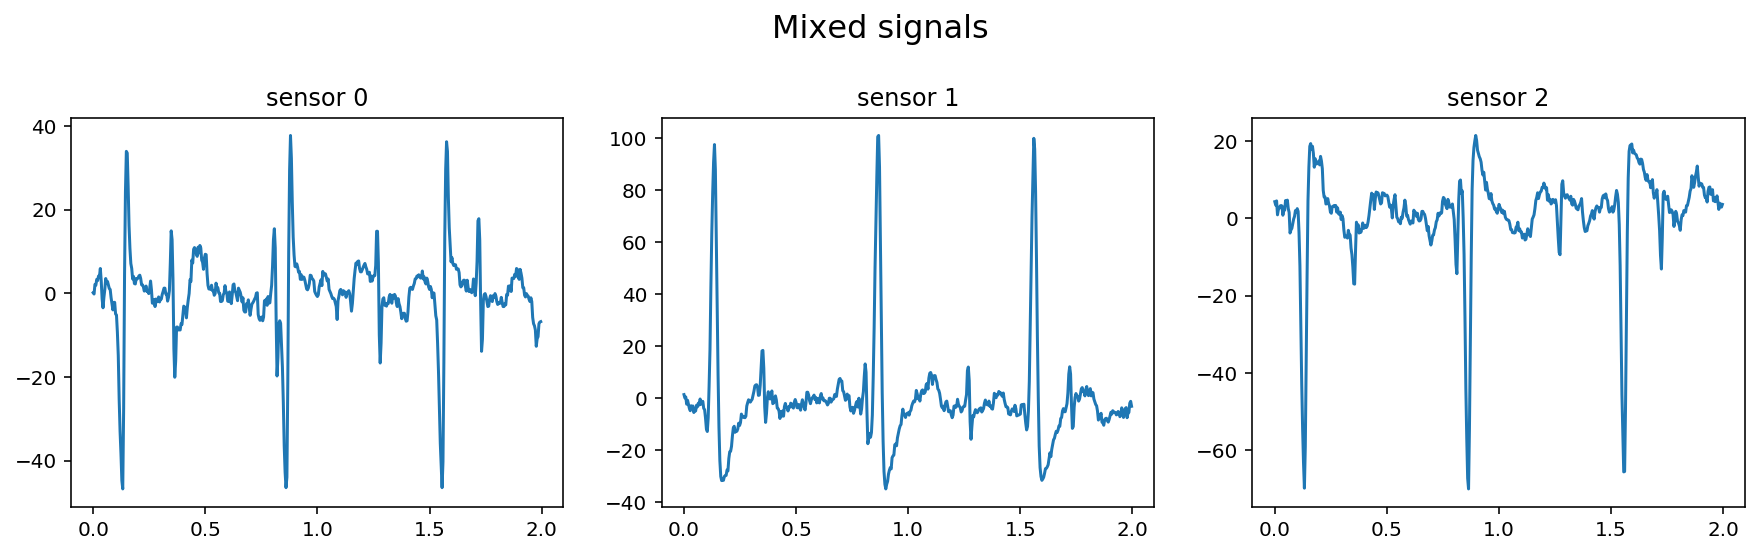

In [33]:
X = df_obs.values

plt.figure(figsize=(15, 4))
for i in range(n_sensors):
    plt.subplot(1, n_sensors, i+1)
    plt.plot(time_steps, X[:, i], linewidth=1.5)
    plt.title('sensor ' + str(i))
plt.suptitle('Mixed signals', size=16)
plt.subplots_adjust(top=0.8)

### Recovering sources using ICA

### FastICA

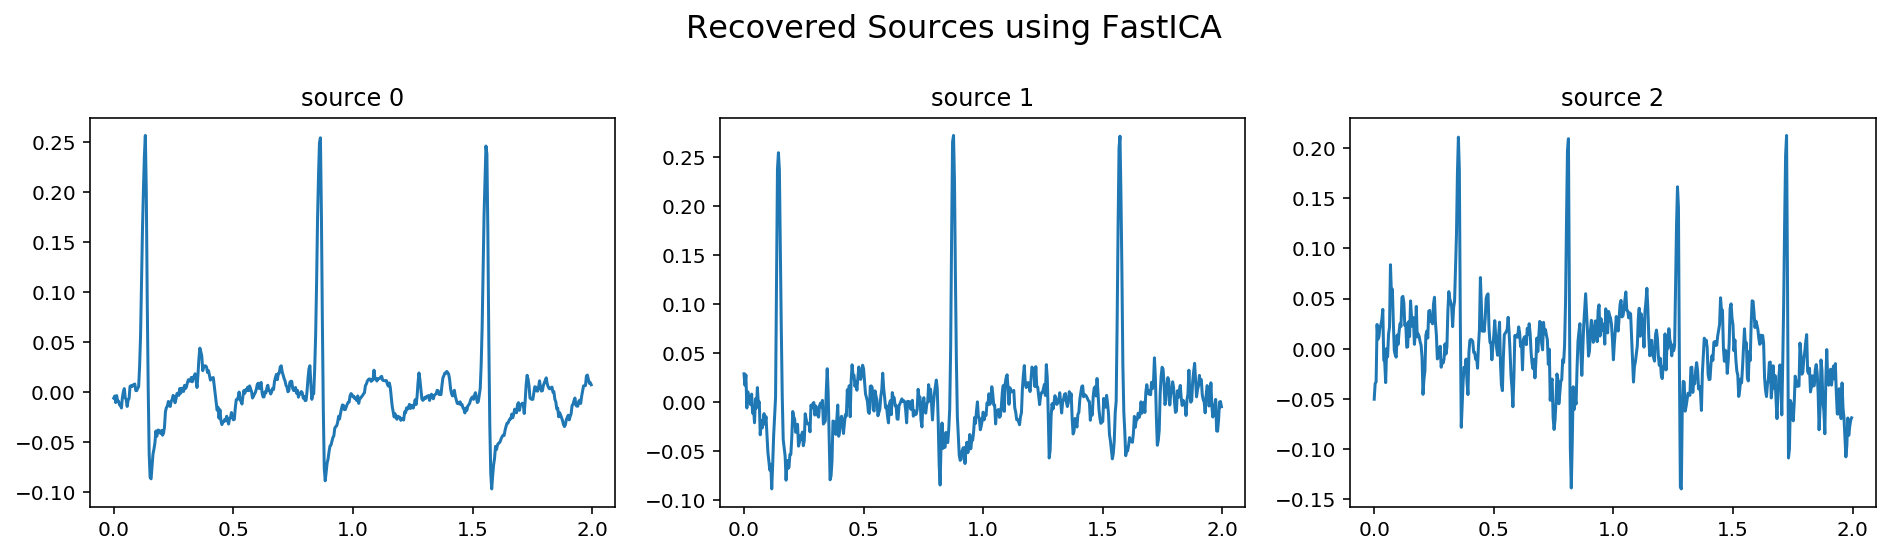

In [36]:
ica = FastICA(n_components=3)
sources = ica.fit_transform(X)

# Plotting results of FastICA
plt.figure(figsize=(16.0, 4.0))
n_mixtures = 3
for i, ylim in zip(range(n_sensors), ylimits):
    plt.subplot(1, n_sensors, i+1)
    plt.plot(time_steps, sources[:, i], linewidth=1.5)
    plt.title('source ' + str(i))
plt.suptitle("Recovered Sources using FastICA", size=16)
plt.subplots_adjust(top=0.8)

In [21]:
# we can see that the sources 0 and 1 belongs to the mother and the source 2 to the fetus
mixing = ica.mixing_

# this may change each time one executes the code above
idx_fetus = [0]
idx_mother = [1, 2]

### First step of MICA: identify the independent subspaces
A_fetus = mixing[:, idx_fetus]
A_mother = mixing[:, idx_mother]
A = [A_fetus, A_mother]

### Second step of MICA: compute projections
projs = orthogonal_proj(A)
P_fetus, P_mother = projs[0], projs[1]

# Projection into the mother subspace
mica_mother = np.dot(P_mother, X.T)

# Projection into the fetus subspace
mica_fetus = np.dot(P_fetus, X.T)

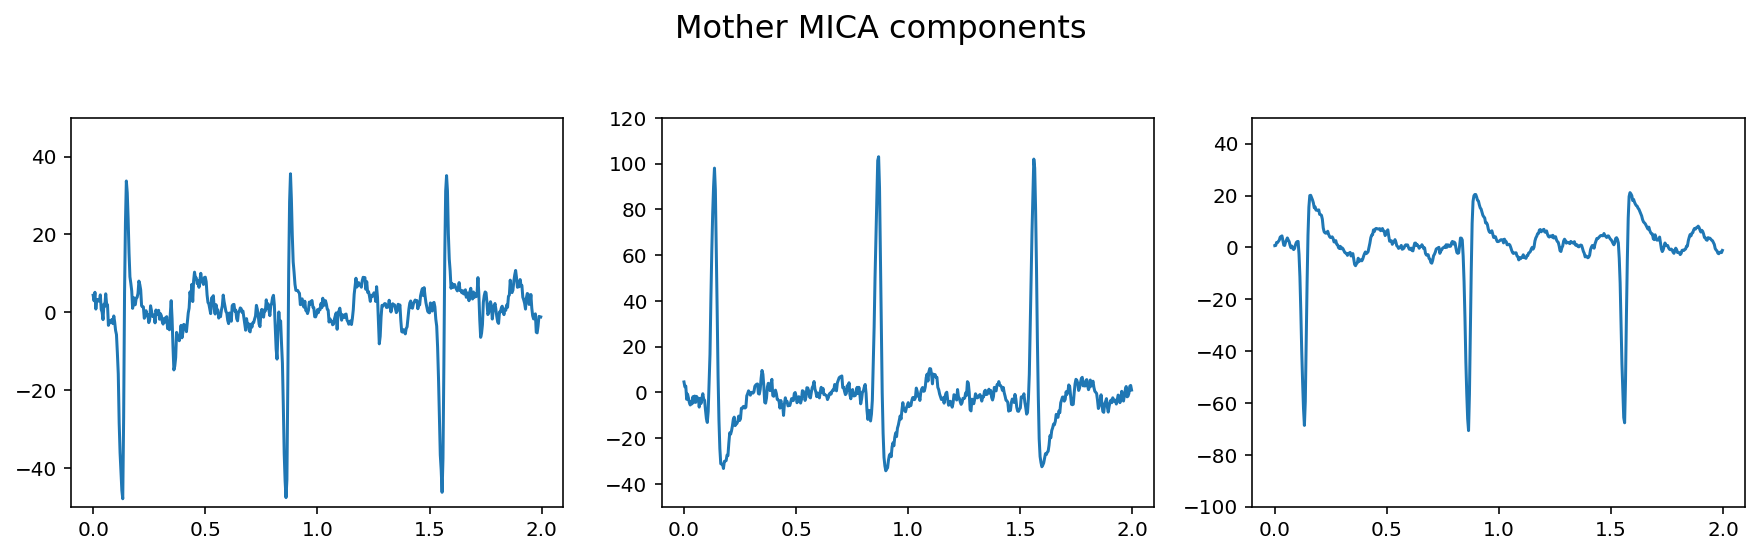

In [28]:
ylimits = [(-50, 50), (-50, 120), (-100, 50)]
plt.figure(figsize=(15, 4))
for i, ylim in zip(range(n_sensors), ylimits):
    plt.subplot(1, n_sensors, i+1)
    plt.plot(time_steps, mica_mother[i,:], linewidth=1.5)
    plt.ylim(ylim[0], ylim[1])
plt.suptitle("Mother MICA components", size=16)
plt.subplots_adjust(top=0.8)

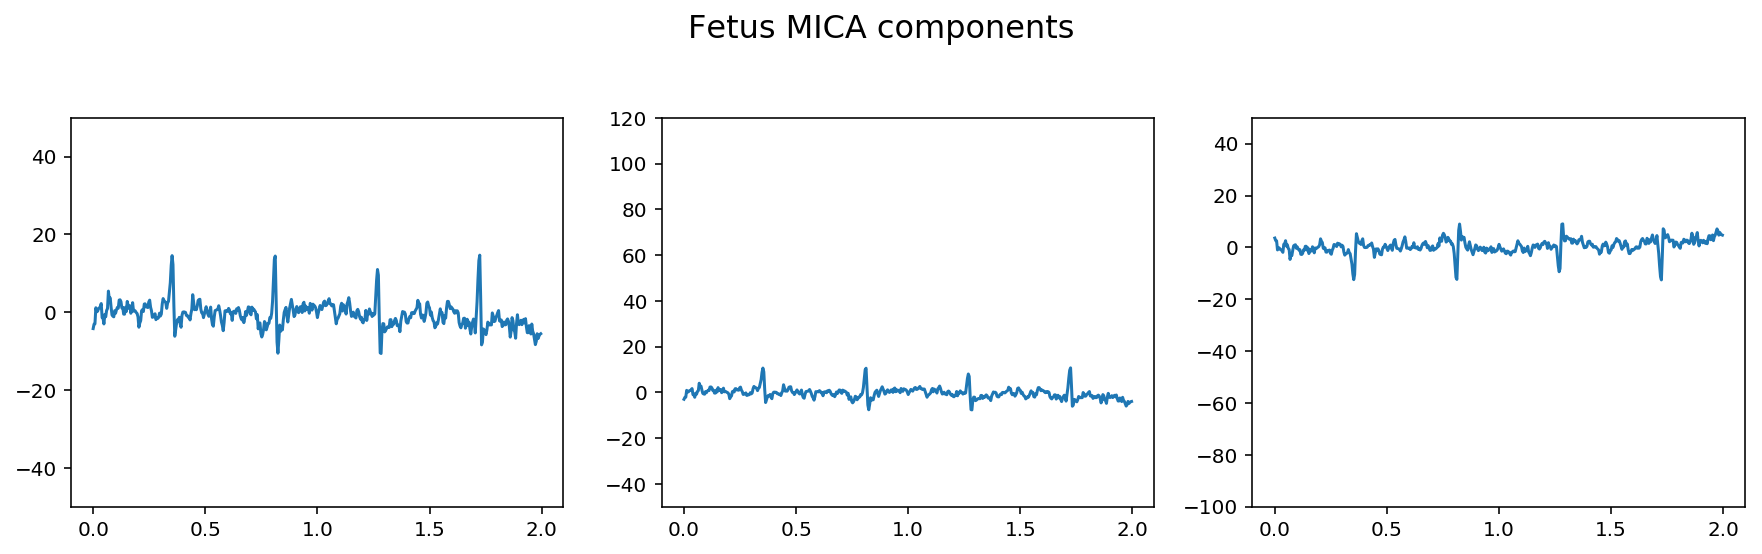

In [27]:
ylimits = [(-50, 50), (-50, 120), (-100, 50)]
plt.figure(figsize=(15, 4))
for i, ylim in zip(range(n_sensors), ylimits):
    plt.subplot(1, n_sensors, i+1)
    plt.plot(time_steps, mica_fetus[i,:], linewidth=1.5)
    plt.ylim(ylim[0], ylim[1])
plt.suptitle("Fetus MICA components", size=16)
plt.subplots_adjust(top=0.8)

### JADE

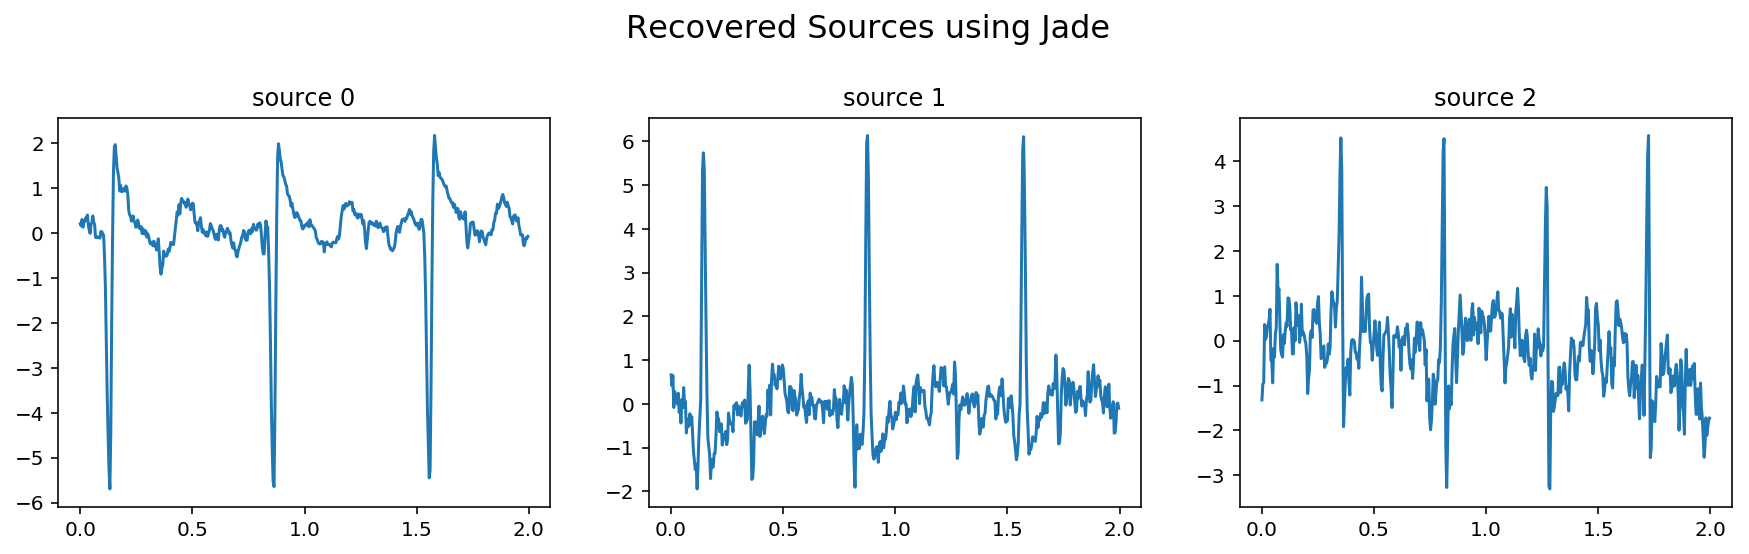

In [37]:
# finding sources using Jade ICA algorithm
unmixing = np.array(jadeR(X.T))

sources = np.dot(unmixing, X.T)

plt.figure(figsize=(15, 4))
for i in range(n_sensors):
    plt.subplot(1, n_sensors, i+1)
    plt.plot(time_steps, sources[i,:], linewidth=1.5)
    plt.title('source ' + str(i))
plt.suptitle("Recovered Sources using Jade", size=16)
plt.subplots_adjust(top=0.8)

In [38]:
# we can see that the sources 0 and 1 belongs to the mother and the source 2 to the fetus
mixing = np.linalg.inv(unmixing)

# this may change each time one executes the code above
idx_fetus = [2]
idx_mother = [0, 1]

### First step of MICA: identify the independent subspaces
A_fetus = mixing[:, idx_fetus]
A_mother = mixing[:, idx_mother]
A = [A_fetus, A_mother]

### Second step of MICA: compute projections
projs = orthogonal_proj(A)
P_fetus, P_mother = projs[0], projs[1]

# Projection into the mother subspace
mica_mother = np.dot(P_mother, X.T)

# Projection into the fetus subspace
mica_fetus = np.dot(P_fetus, X.T)

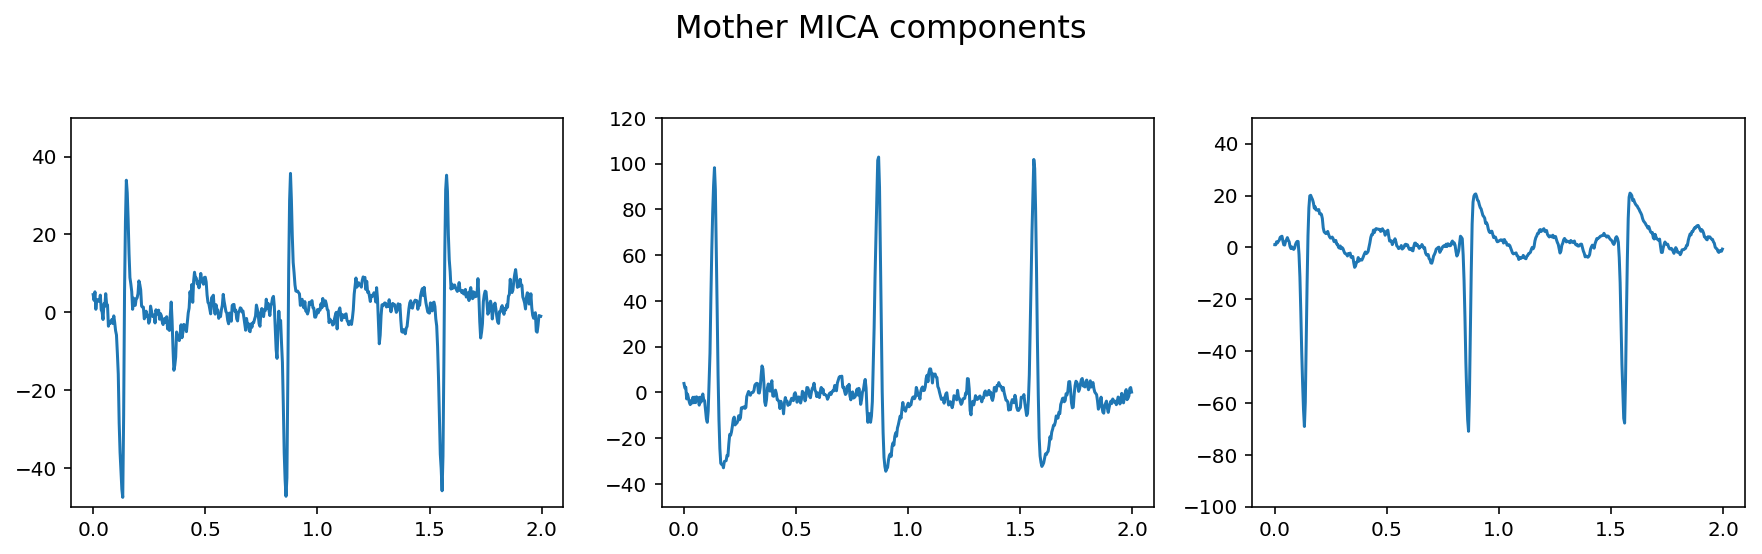

In [39]:
plt.figure(figsize=(15, 4))
ylimits = [(-50, 50), (-50, 120), (-100, 50)]
for i, ylim in zip(range(n_sensors), ylimits):
    plt.subplot(1, n_sensors, i+1)
    plt.plot(time_steps, mica_mother[i,:], linewidth=1.5)
    plt.ylim(ylim[0], ylim[1])
plt.suptitle("Mother MICA components", size=16)
plt.subplots_adjust(top=0.8)

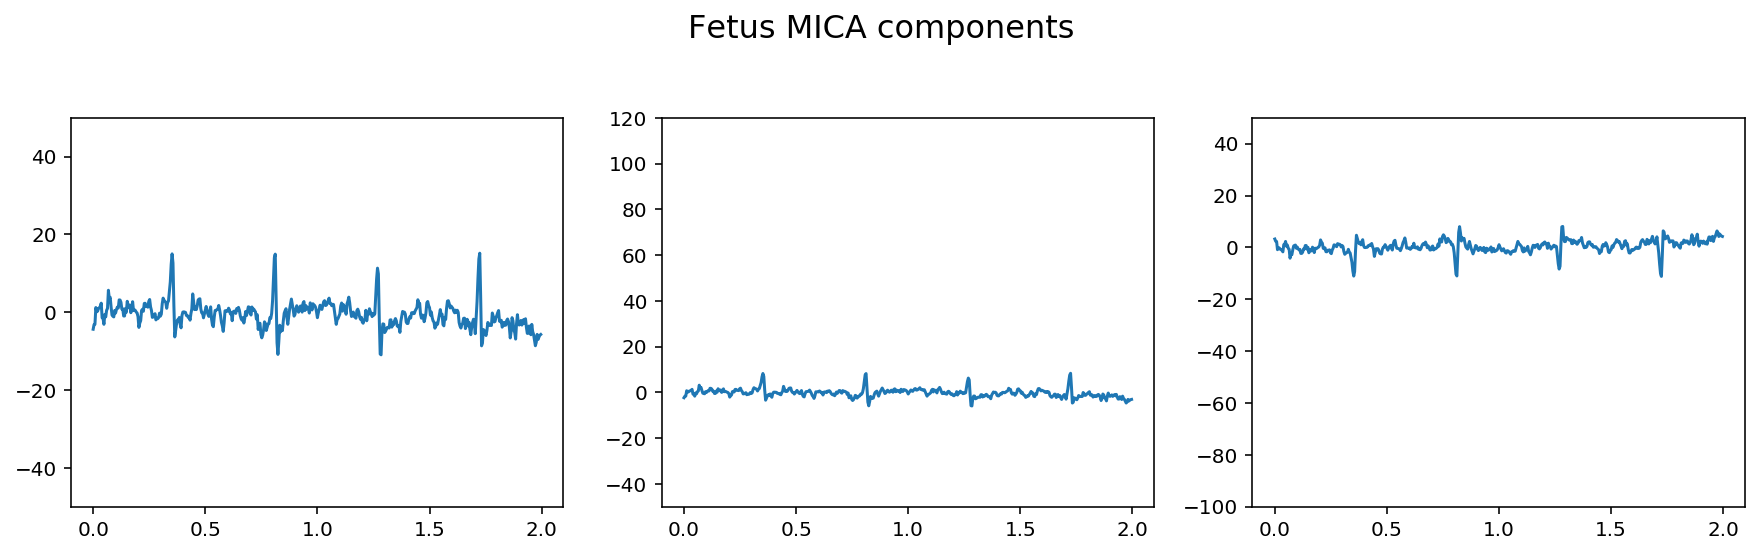

In [40]:
plt.figure(figsize=(15, 4))
ylimits = [(-50, 50), (-50, 120), (-100, 50)]
for i, ylim in zip(range(n_sensors), ylimits):
    plt.subplot(1, n_sensors, i+1)
    plt.plot(time_steps, mica_fetus[i,:], linewidth=1.5)
    plt.ylim(ylim[0], ylim[1])
plt.suptitle("Fetus MICA components", size=16)
plt.subplots_adjust(top=0.8)

## Testing MICA on images

https://github.com/dieggoluis/Multidimensional-ICA/tree/master/data

### Loading images

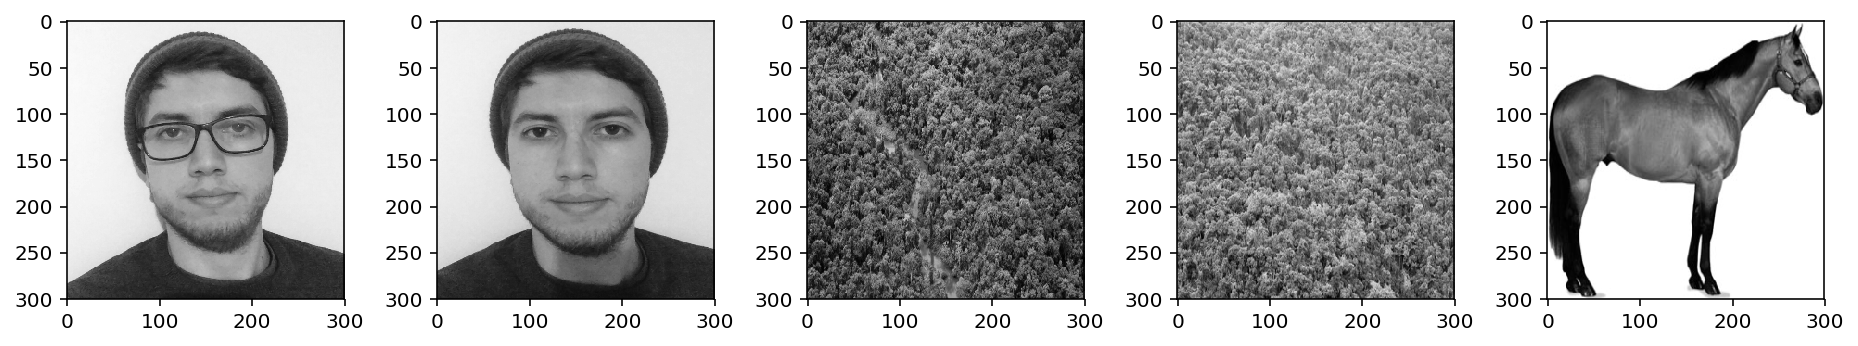

In [145]:
images = ['diego1.jpg', 'diego2.jpg', 'rainforest1.jpg', 'rainforest2.jpg', 'horse.jpg']
sources = [imread('data/' + image, as_grey=True) for image in images]

# same size
width = 300
height = 300

# number of independent subspaces
n_subspaces = 3

sources = np.array(map(lambda img: resize(img, (width, height)), sources))

plt.figure(figsize=(13, 5))
for i, img in enumerate(sources):
    plt.subplot(1, 5, i+1)
    imshow(img, cmap='gray')

### Mixing sources

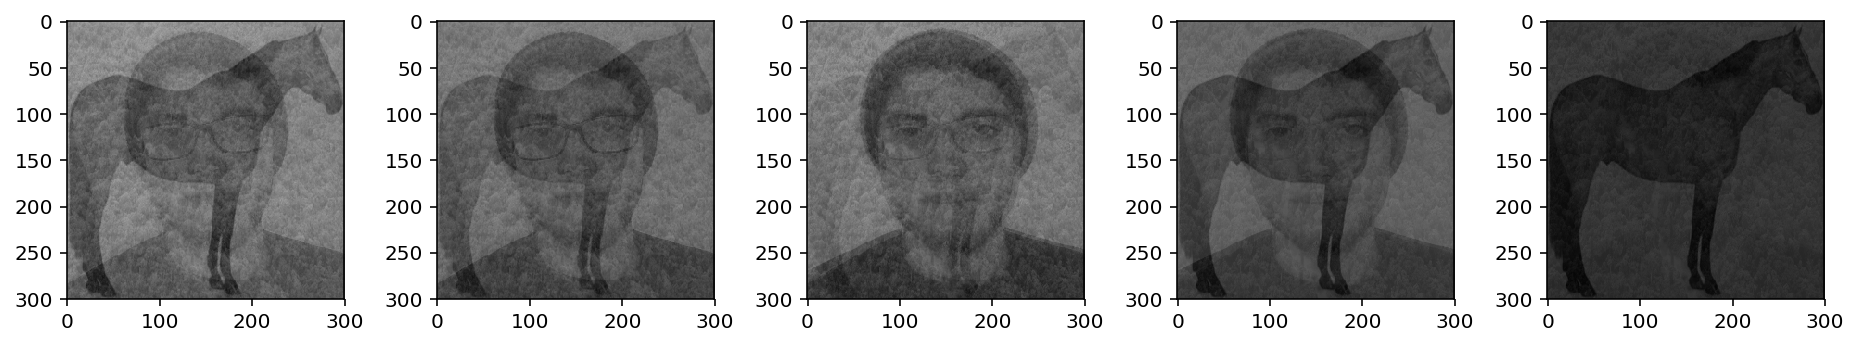

In [146]:
n_sources = len(sources)

X = []
plt.figure(figsize=(13, 5))
for i in range(n_sources):
    mixture_matrix = np.random.random(size=n_sources)/n_sources
    mixture_matrix = mixture_matrix.reshape(-1, 1)
    mixed_image = np.dot(sources.T, mixture_matrix).T[0]
    plt.subplot(1, n_sources, i+1)
    imshow(mixed_image, cmap='gray')
    X.append(mixed_image)
    
X = np.asarray(X).reshape(n_sources, width * height)

### Recovering sources using ICA

### FastICA

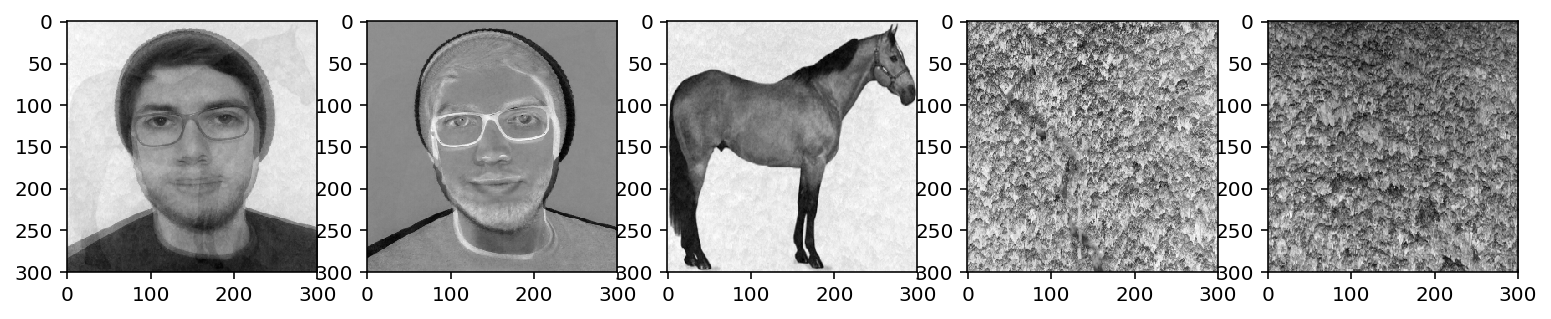

In [147]:
# First step of MICA: find sources (maybe dependent) using a ICA algorithm
ica = FastICA(n_components=n_sources)
y = ica.fit_transform(X.T).T
mixing = ica.mixing_

plt.figure(figsize=(13, 5))
for i in range(n_sources):
    plt.subplot(1, n_sources, i+1)
    plt.imshow(y[i].reshape(width, height), cmap='gray')

In [148]:
# automatically identify dependent sources

# hog image descriptor
hog_images = np.asarray([hog(y[i].reshape(300, 300)) for i in range(n_sources)])
# use kmeans to find labels
kmeans = KMeans(n_subspaces).fit(cosine_similarity(hog_images, hog_images))

# index of each subspace
idx_subspaces = [np.argwhere(kmeans.labels_ == i)[:,0] for i in range(n_subspaces)]
idx_subspaces

[array([0, 1]), array([2]), array([3, 4])]

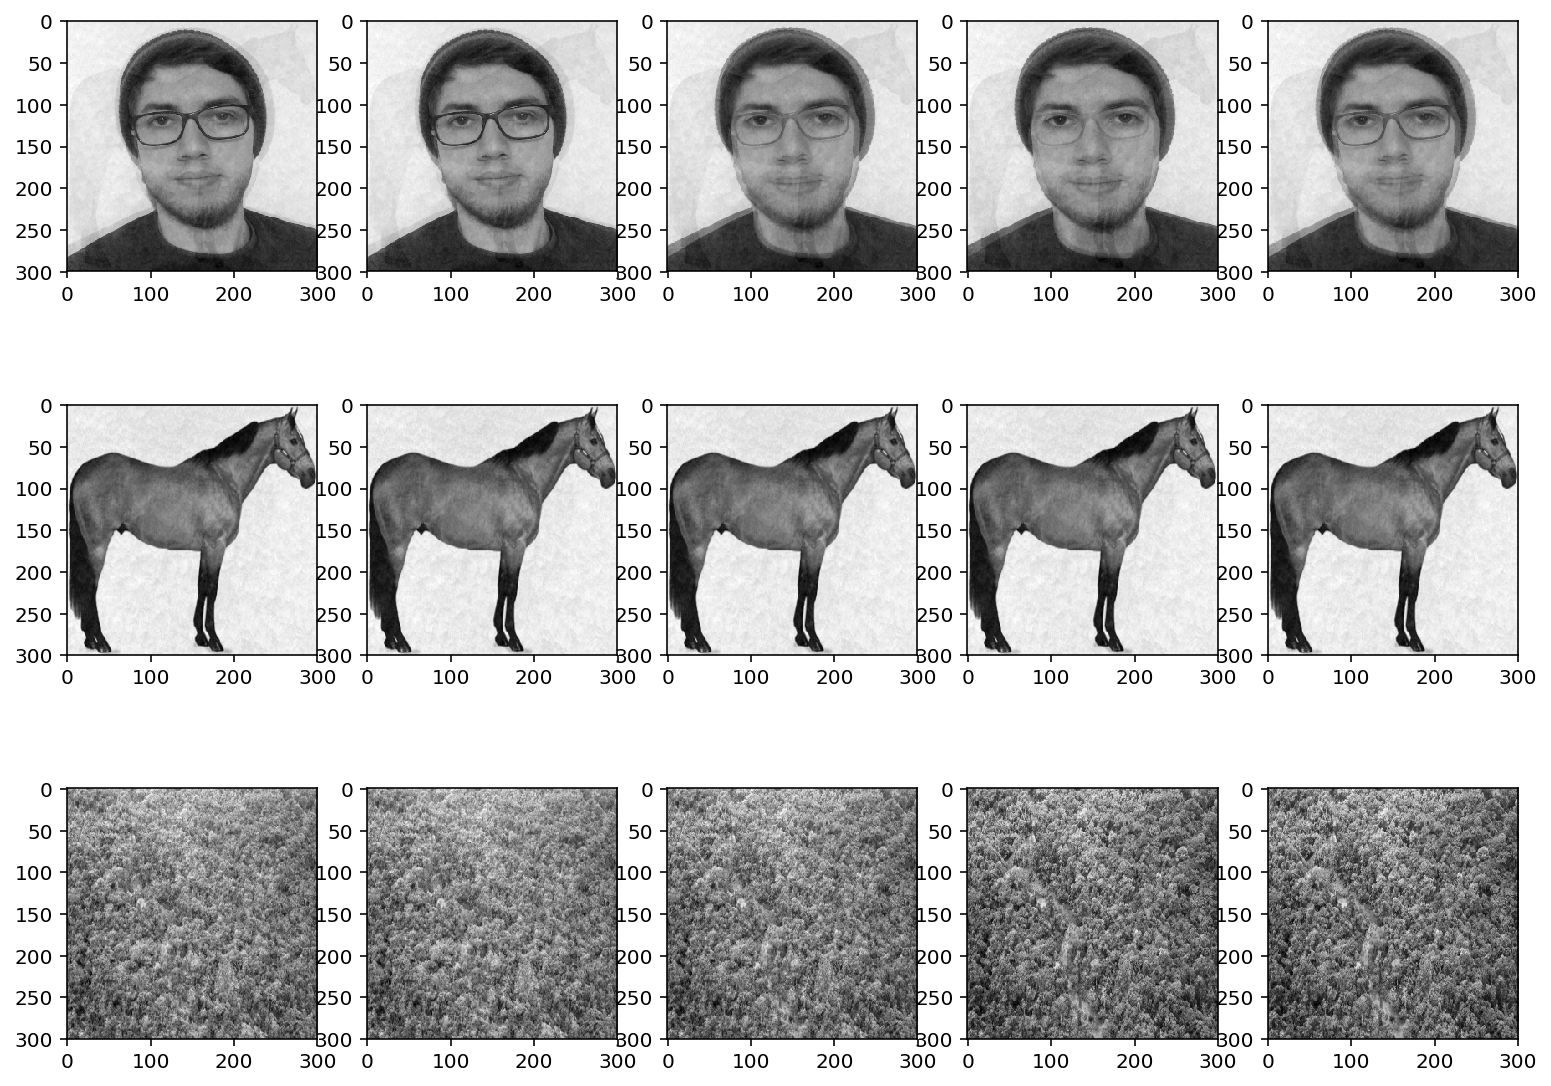

In [149]:
subspaces = [mixing[:, idx_subspace] for idx_subspace in idx_subspaces]

# compute projections into each subspace
projs = orthogonal_proj(subspaces)

# plot mixed sources into each subspace
plt.figure(figsize=(13, 10))
for i, p in enumerate(projs):
    imgs = np.dot(p, X)
    for j, img in enumerate(imgs):
        plt.subplot(len(projs), n_sources, i*n_sources + j + 1)
        plt.imshow(img.reshape(width, height), cmap='gray')

### JADE

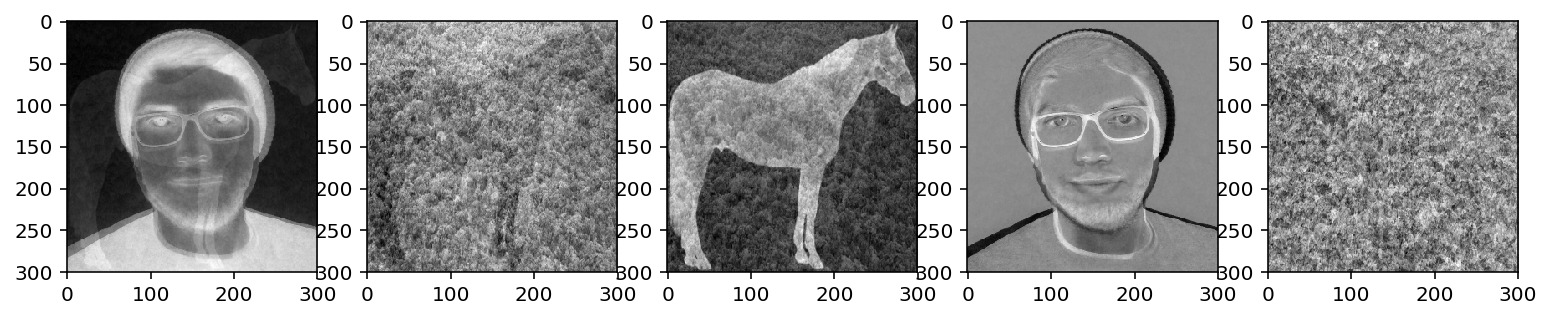

In [157]:
# First step of MICA: find sources (maybe dependent) using a ICA algorithm
unmixing = np.array(jadeR(X, m=n_sources))
mixing = np.linalg.inv(unmixing)
y = np.dot(unmixing, X)

plt.figure(figsize=(13, 5))
for i in range(n_sources):
    plt.subplot(1, n_sources, i+1)
    plt.imshow(y[i].reshape(width, height), cmap='gray')

In [158]:
# automatically identify dependent sources

# hog image descriptor
hog_images = np.asarray([hog(y[i].reshape(300, 300)) for i in range(n_sources)])
# use kmeans to find labels
kmeans = KMeans(n_subspaces).fit(cosine_similarity(hog_images, hog_images))

# index of each subspace
idx_subspaces = [np.argwhere(kmeans.labels_ == i)[:,0] for i in range(n_subspaces)]
idx_subspaces

[array([1, 4]), array([0, 3]), array([2])]

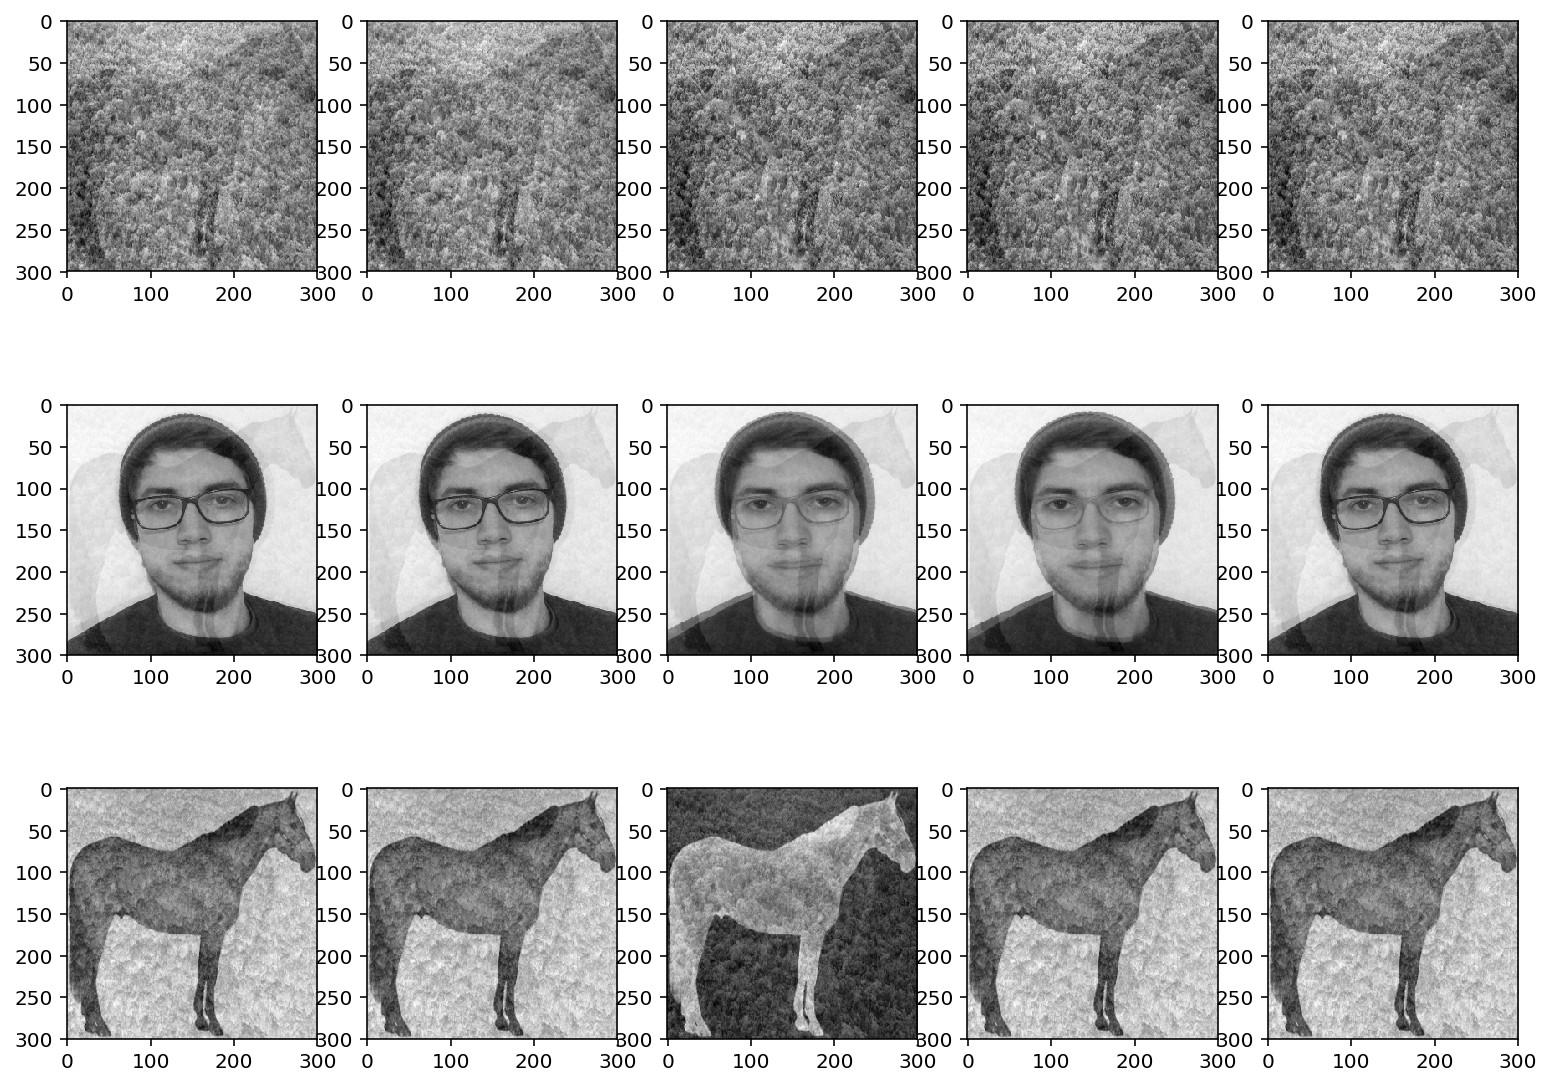

In [159]:
subspaces = [mixing[:, idx_subspace] for idx_subspace in idx_subspaces]

# compute projections into each subspace
projs = orthogonal_proj(subspaces)

# plot mixed sources into each subspace
plt.figure(figsize=(13, 10))
for i, p in enumerate(projs):
    imgs = np.dot(p, X)
    for j, img in enumerate(imgs):
        plt.subplot(len(projs), n_sources, i*n_sources + j + 1)
        plt.imshow(img.reshape(width, height), cmap='gray')

### What if we use faces from difference persons

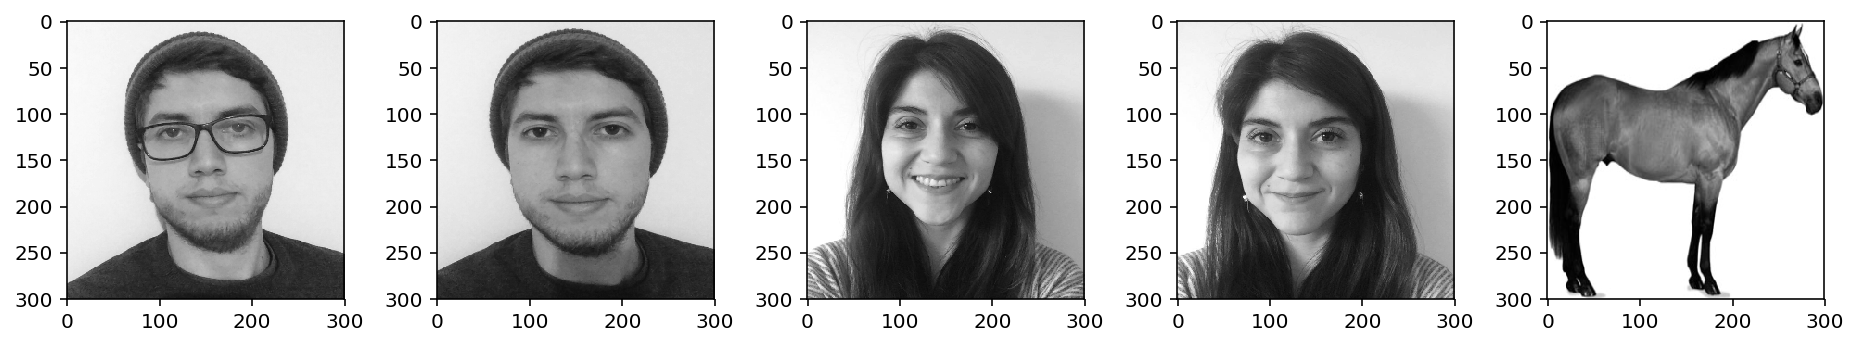

In [5]:
images = ['diego1.jpg', 'diego2.jpg', 'javi1.jpeg', 'javi2.jpeg', 'horse.jpg']
sources = [imread('data/' + image, as_grey=True) for image in images]

# same size
width = 300
height = 300

# number of independent subspaces
n_subspaces = 3

sources = np.array(map(lambda img: resize(img, (width, height)), sources))

plt.figure(figsize=(13, 5))
for i, img in enumerate(sources):
    plt.subplot(1, 5, i+1)
    imshow(img, cmap='gray')

### Mixing sources

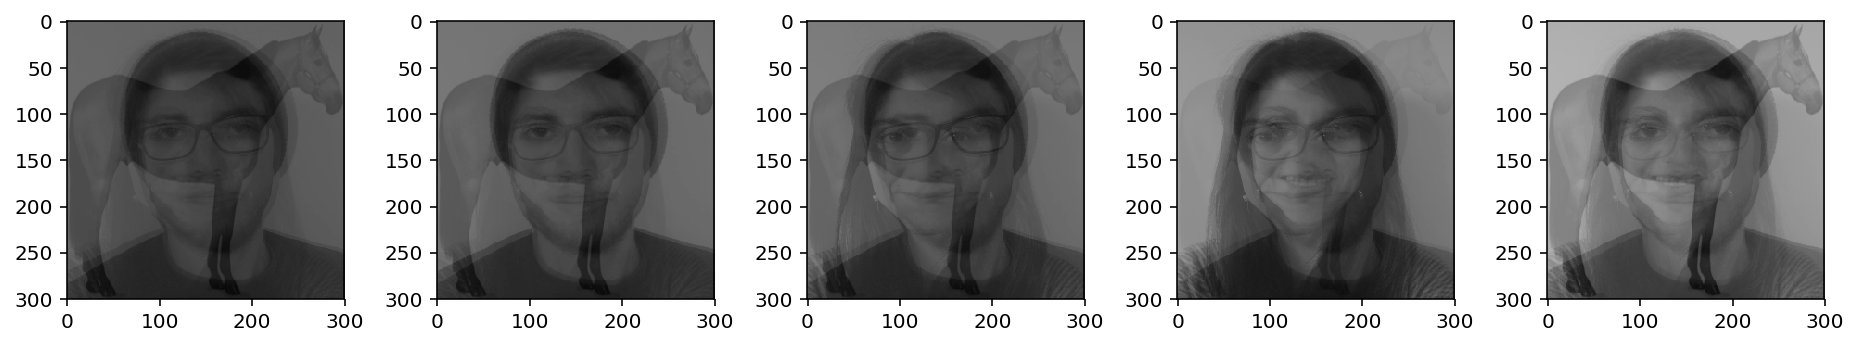

In [6]:
n_sources = len(sources)

X = []
plt.figure(figsize=(13, 5))
for i in range(n_sources):
    mixture_matrix = np.random.random(size=n_sources)/n_sources
    mixture_matrix = mixture_matrix.reshape(-1, 1)
    mixed_image = np.dot(sources.T, mixture_matrix).T[0]
    plt.subplot(1, n_sources, i+1)
    imshow(mixed_image, cmap='gray')
    X.append(mixed_image)
    
X = np.asarray(X).reshape(n_sources, width * height)

### Recovering sources using ICA

### FastICA

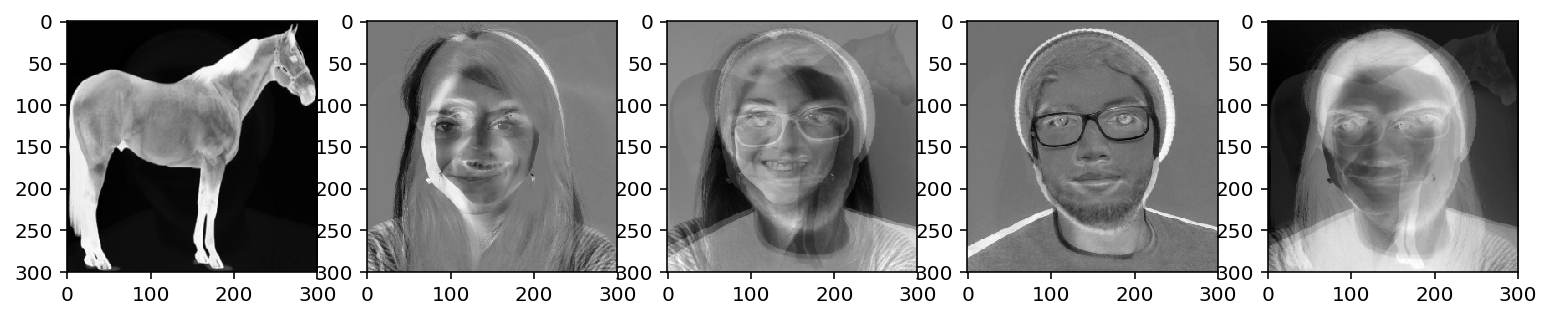

In [8]:
# First step of MICA: find sources (maybe dependent) using a ICA algorithm
ica = FastICA(n_components=n_sources)
y = ica.fit_transform(X.T).T
mixing = ica.mixing_

plt.figure(figsize=(13, 5))
for i in range(n_sources):
    plt.subplot(1, n_sources, i+1)
    plt.imshow(y[i].reshape(width, height), cmap='gray')

In [14]:
# automatically identify dependent sources

# hog image descriptor
hog_images = np.asarray([hog(y[i].reshape(300, 300)) for i in range(n_sources)])
# use kmeans to find labels
kmeans = KMeans(n_subspaces).fit(cosine_similarity(hog_images, hog_images))

# index of each subspace
idx_subspaces = [np.argwhere(kmeans.labels_ == i)[:,0] for i in range(n_subspaces)]
idx_subspaces

[array([3]), array([1, 2, 4]), array([0])]

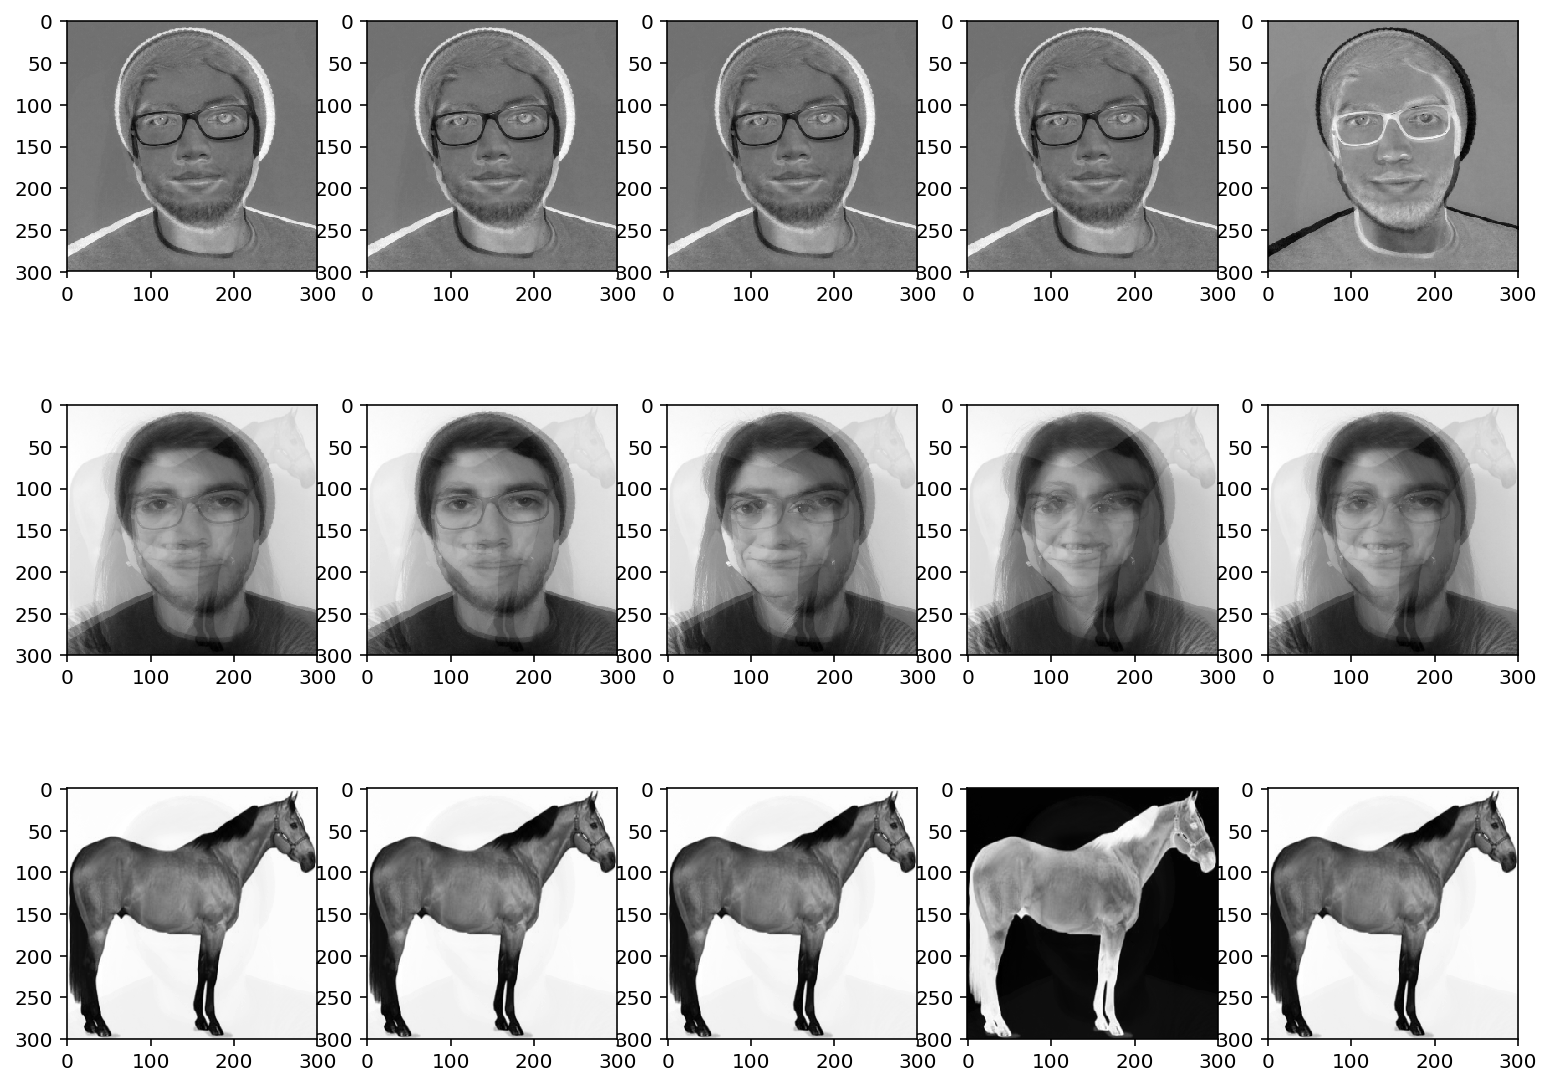

In [15]:
subspaces = [mixing[:, idx_subspace] for idx_subspace in idx_subspaces]

# compute projections into each subspace
projs = orthogonal_proj(subspaces)

# plot mixed sources into each subspace
plt.figure(figsize=(13, 10))
for i, p in enumerate(projs):
    imgs = np.dot(p, X)
    for j, img in enumerate(imgs):
        plt.subplot(len(projs), n_sources, i*n_sources + j + 1)
        plt.imshow(img.reshape(width, height), cmap='gray')

#### MICA cannot identify well the face subpsaces, since the faces subspaces are actually dependent. 